In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IsingSolutions import ising2d_exact, ising3d_monte_carlo as ising3d_mc
from TNModels import AKLT3D
from scipy.interpolate import interp1d,PchipInterpolator
from glob import glob
import numpy as np
import os
from tqdm.auto import tqdm
import json

In [3]:
task_name='AKLT3D_X10_scan_grid_critical_a3'
critical_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}

  0%|          | 0/110 [00:00<?, ?it/s]

loaded 110 files
missing a1=0.2309401076758503,a2=2.921186973360886
missing a1=0.2309401076758503,a2=3.286335345030997
missing a1=0.2309401076758503,a2=3.651483716701108
missing a1=0.0,a2=2.921186973360886
missing a1=0.0,a2=3.286335345030997
missing a1=0.0,a2=3.651483716701108
missing a1=0.0,a2=2.1908902300206647
missing a1=0.0,a2=2.5560386016907755
missing a1=0.4618802153517006,a2=3.651483716701108
missing a1=0.6928203230275509,a2=3.286335345030997
missing a1=1.3856406460551018,a2=3.651483716701108
file saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/Tc.csv


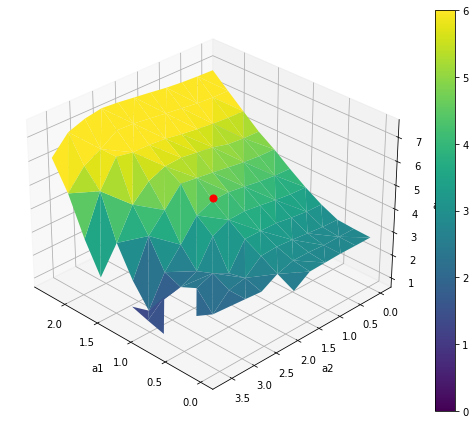

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/surface_plot.png


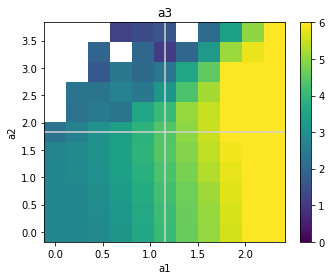

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


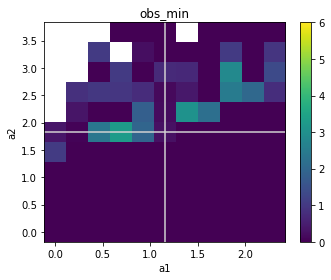

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


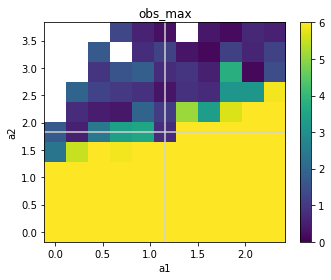

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


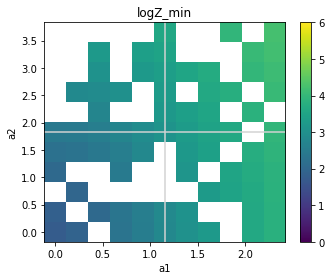

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


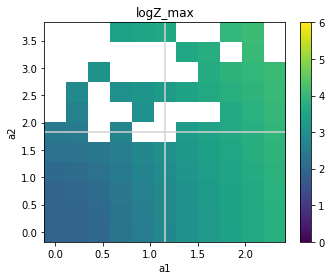

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

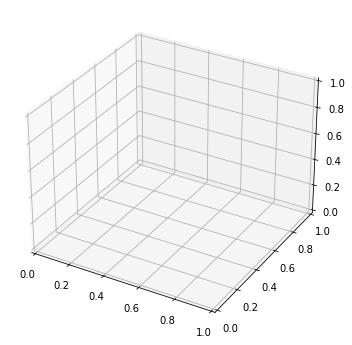

In [16]:
def transform_params(a0,a1,a2,a3):
    b0=a0
    b2=-49/36*a0+3/2*a1-3/20*a2+1/90*a3
    b4=7/18*a0-13/24*a1+1/6*a2-1/72*a3
    b6=-1/36*a0+1/24*a1-1/60*a2+1/360*a3
    return b0,b2,b4,b6

critical_params['a0']=1
critical_params['b0'],critical_params['b2'],critical_params['b4'],critical_params['b6']=transform_params(critical_params['a0'],critical_params['a1'],critical_params['a2'],critical_params['a3'])

def load_df(filenames):
    filenames=sorted(filenames,key=lambda x:os.path.getmtime(x))
    df=[]
    for filename in tqdm(filenames):
        data=json.load(open(filename,'r'))
        lastData=data[-1]
        # print(filename)
        df.append({**lastData['params_new'],
                   'obs_new':lastData['obs_new'],'obs_min':lastData['obs_min'],'obs_max':lastData['obs_max'],
                   'logZ_new':lastData['logZ_new'],'logZ_min':lastData['logZ_min'],'logZ_max':lastData['logZ_max'],
        })
    print('loaded {} files'.format(len(df)))
    df=pd.DataFrame(df)
    return df
def fix_grid(df):
    df1=[]
    for a1 in df.a1.unique():
        for a2 in df.a2.unique():
            # find one or None
            df2=df[(df.a1==a1)&(df.a2==a2)]
            if len(df2)==0:
                print('missing a1={},a2={}'.format(a1,a2))
                df1.append({'a1':a1,'a2':a2,'a3':np.nan,'logZ':np.nan,'obs':np.nan})
            else:
                df1.append(df2.iloc[0].to_dict())
    return pd.DataFrame(df1)

def process_df(df):
    df['a0']=1
    df['b0'],df['b2'],df['b4'],df['b6']=transform_params(df['a0'],df['a1'],df['a2'],df['a3'])
    return df

def surface_plot_section(df,grid_param_names=['a1','a2'],obs_name='a3',axis_param_names=['a1','a2'],clim=None,filename=None):
    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111,projection='3d')
    df=df.sort_values(by=grid_param_names)
    p=ax.plot_trisurf(df[axis_param_names[0]],df[axis_param_names[1]],df[obs_name],cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    # p=ax.scatter(df[axis_param_names[0]],df[axis_param_names[1]],df[obs_name],c=df[obs_name],cmap='viridis',s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    ax.set_xlabel(axis_param_names[0]);ax.set_ylabel(axis_param_names[1]);ax.set_zlabel(obs_name)
    # rotate camera 
    ax.view_init(30, 135)
    ax.scatter(critical_params[axis_param_names[0]],critical_params[axis_param_names[1]],critical_params[obs_name],c='r',s=50)
    fig.colorbar(p)
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')



def image_plot_2D(df,grid_param_names=['a1','a2'],obs_name='a3',clim=None,filename=None):
    fig=plt.figure(figsize=(5,4))
    plt.axhline(critical_params[grid_param_names[1]],c='lightgrey')
    plt.axvline(critical_params[grid_param_names[0]],c='lightgrey')
    df=df.sort_values(by=grid_param_names)
    a1s=np.unique(df[grid_param_names[0]])
    a2s=np.unique(df[grid_param_names[1]])
    obs=df[obs_name].values.reshape(len(a2s),len(a1s)).T
    def get_image_extent(xs,ys):
        return [xs[0]-(xs[1]-xs[0])/2,xs[-1]+(xs[1]-xs[0])/2,ys[0]-(ys[1]-ys[0])/2,ys[-1]+(ys[1]-ys[0])/2]
    plt.imshow(obs,origin='lower',extent=get_image_extent(a1s,a2s),aspect='auto',cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    # plt.scatter(df['a1'],df['a2'],c=df[obs_name],s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    plt.xlabel(grid_param_names[0]);plt.ylabel(grid_param_names[1]);plt.title(obs_name)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')

df=load_df(glob('./data/{task_name}/*/Tc.json'.format(task_name=task_name)))
df=fix_grid(df)
df=process_df(df)
os.makedirs('./data_output/{task_name}/'.format(task_name=task_name),exist_ok=True)
df.to_csv('./data_output/{task_name}/Tc.csv'.format(task_name=task_name),index=False)
print('file saved to ./data_output/{task_name}/Tc.csv'.format(task_name=task_name))

%matplotlib inline

surface_plot_section(df,obs_name='a3',clim=[0,6],filename='./data_output/{}/surface_plot.png'.format(task_name))
image_plot_2D(df,obs_name='a3',clim=[0,6],filename='./data_output/{}/image_plot.png'.format(task_name))
image_plot_2D(df,obs_name='obs_min',clim=[0,6],filename='./data_output/{}/image_plot.png'.format(task_name))
image_plot_2D(df,obs_name='obs_max',clim=[0,6],filename='./data_output/{}/image_plot.png'.format(task_name))
image_plot_2D(df,obs_name='logZ_min',clim=[0,6],filename='./data_output/{}/image_plot.png'.format(task_name))
image_plot_2D(df,obs_name='logZ_max',clim=[0,6],filename='./data_output/{}/image_plot.png'.format(task_name))

surface_plot_section(df,axis_param_names=['b2','b4'],obs_name='b6',clim=[0,6],filename='./data_output/{}/surface_plot_b.png'.format(task_name))

a3=2.237176*a1+0.203823*a2+1.500819


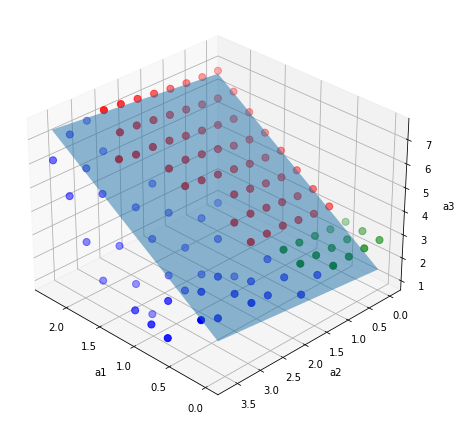

In [15]:
region1_mask=(df['obs_max']>3)&(df['a1']>0.5)
region2_mask=(df['obs_max']>3)&(df['a1']<0.5)
region3_mask=(df['obs_max']<3)

from scipy.optimize import curve_fit
def f(x,a,b,c):
    return a*x[0]+b*x[1]+c
a1,a2,a3=df[region1_mask][['a1','a2','a3']].values.T
popt,pcov=curve_fit(f,[a1,a2],a3)
print('a3={:.6f}*a1+{:.6f}*a2+{:.6f}'.format(*popt))

%matplotlib inline

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,projection='3d')
ax.set_xlabel('a1');ax.set_ylabel('a2');ax.set_zlabel('a3')
a1l,a2l=np.linspace(np.min(df['a1']),np.max(df['a1']),2),np.linspace(np.min(df['a2']),np.max(df['a2']),2);a1l,a2l=np.meshgrid(a1l,a2l);a3l=f([a1l,a2l],*popt)
ax.plot_surface(a1l,a2l,a3l,alpha=0.5)
ax.scatter(df[region1_mask]['a1'],df[region1_mask]['a2'],df[region1_mask]['a3'],color='r',s=50)
ax.scatter(df[region2_mask]['a1'],df[region2_mask]['a2'],df[region2_mask]['a3'],color='g',s=50)
ax.scatter(df[region3_mask]['a1'],df[region3_mask]['a2'],df[region3_mask]['a3'],color='b',s=50)
ax.view_init(30, 135)

plt.tight_layout()
plt.show()


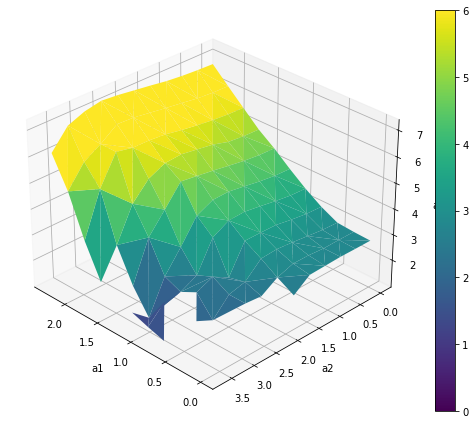

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/surface_plot.png


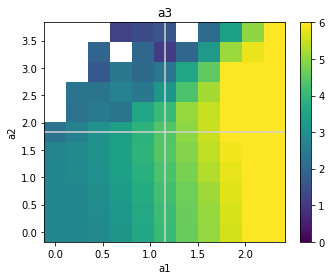

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


In [16]:
# %matplotlib widget







      fun: 14.617860354615566
 hess_inv: array([[ 9.99326304e+10, -3.28517631e+09, -2.92959632e+10],
       [-3.28517631e+09,  1.07996591e+08,  9.63072862e+08],
       [-2.92959632e+10,  9.63072862e+08,  8.58832052e+09]])
      jac: array([-2.82526016e-05,  1.49846077e-04, -1.13606453e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 40
     njev: 110
   status: 2
  success: False
        x: array([ 70261.31300151,  -2309.27065567, -20597.57278617])


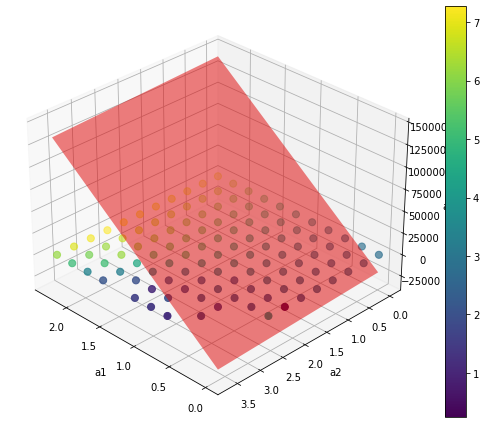

In [11]:
from scipy.optimize import minimize

# fit a3 with linear a1,a2 within tolerance
def fit_plane_with_tol(a1,a2,a3,tol=1,initial_guess=None):
    def loss(params, a1,a2,a3):
        a,b,c=params # plane ax+by+cz=1
        # dist to plane = |ax+by+cz-1|/sqrt(a^2+b^2+c^2)
        residue=(a1*a+a2*b+a3*c-1)/np.sqrt(a**2+b**2+c**2)
        return np.sum(residue**2)
        # return np.sum(np.where(np.abs(residue)<=tol,0.5*residue**2,tol*(np.abs(residue)-0.5*tol)))
    initial_guess=initial_guess or [1,1,1]
    res=minimize(loss,initial_guess,args=(a1,a2,a3))
    print(res)
    return res.x

initial_guess=[ 2.19097465, -0.46855692,  3.29293665]

params=fit_plane_with_tol(df['a1'],df['a2'],df['a3'],tol=99999,initial_guess=initial_guess)

a1_min,a1_max=df['a1'].min(),df['a1'].max()
a2_min,a2_max=df['a2'].min(),df['a2'].max()
a1s=np.linspace(a1_min,a1_max,2)
a2s=np.linspace(a2_min,a2_max,2)
a1s,a2s=np.meshgrid(a1s,a2s)
a3s=params[0]*a1s+params[1]*a2s+params[2]

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,projection='3d')

p=ax.scatter(df['a1'],df['a2'],df['a3'],c=df['a3'],cmap='viridis',s=50)

ax.plot_surface(a1s,a2s,a3s,alpha=0.5,color='red')

ax.set_xlabel('a1');ax.set_ylabel('a2');ax.set_zlabel('a3')
# rotate camera 

ax.view_init(30, 135)
fig.colorbar(p)
plt.tight_layout()
plt.show()